In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import math
import seaborn as sns

Load dateset and display basic information

In [3]:
df = pd.read_csv('./datasets/full_cleaned_dataset.csv')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 921 entries, 0 to 920
Columns: 111 entries, Unnamed: 0 to marketcap
dtypes: float64(91), int64(15), object(5)
memory usage: 798.8+ KB


Calcualte the Altman-Z score for each observation (where possible)
And show the top and bottom 5 companies based on the Altman-Z score

In [4]:
df["z_score"] = 1.2*(df["totalCurrentAssets"]/df["totalAssets"]) + 1.4*df["retainedEarnings"]/df["totalAssets"] + 3.3 * (df["ebitda"]-df["depreciationAndAmortization_income_statement"])/df["totalAssets"] + 0.6*df["marketcap"] / df["totalLiabilities"] + 0.999*df["revenue"]/df["totalAssets"]
df["z_score"] = df["z_score"].round(2)
df.dropna(subset=['z_score'], inplace=True)

df_zscore_analysis = df[['symbol', 'year', 'z_score', 'distressed', 'totalCurrentAssets', 'totalAssets', 'retainedEarnings', 'ebitda', 'depreciationAndAmortization_income_statement', 'totalLiabilities', 'marketcap', 'revenue']]
df_zscore_print = df[['symbol', 'year', 'z_score', 'distressed']]
print(df_zscore_print.sort_values(by=['z_score'], ascending=False).head(10))
print(df_zscore_print.sort_values(by=['z_score'], ascending=True).head(10))

      symbol  year  z_score  distressed
141  BION.SW  2020    46.41           0
105  BANB.SW  2021    41.12           0
296  EMSN.SW  2021    35.45           0
144  BEAN.SW  2021    34.99           0
142  BEAN.SW  2023    34.77           0
297  EMSN.SW  2020    33.59           0
145  BEAN.SW  2020    32.48           0
294  EMSN.SW  2023    32.25           0
661  SENS.SW  2023    26.94           0
663  SENS.SW  2021    25.52           0
      symbol  year  z_score  distressed
16   ADXN.SW  2023  -113.64           0
17   ADXN.SW  2022   -64.61           0
18   ADXN.SW  2021   -16.77           0
19   ADXN.SW  2020   -15.86           0
638  SANN.SW  2022   -15.77           0
397  IDIA.SW  2023    -9.46           0
640  SANN.SW  2020    -9.39           0
639  SANN.SW  2021    -9.15           0
853  WIHN.SW  2023    -7.41           0
854  WIHN.SW  2022    -6.28           0


The Altman-Z score is usually interpreted as follows:
- Z > 3.0: Safe zone
- 1.8 < Z < 3.0: Grey zone
- Z < 1.8: Distress zone

Looking at the top and bottom 10, we get very extreme values (above 25 and below -6) which are likely due to the faulty or inaccurate data. These entries should be considered as outliers and removed for further analysis.
Interestingly, in the bottom 10, we don't have companies that we considered to be distressed. In a next step let's take a look at the score of the distressed companies.

In [5]:
print(df_zscore_print.where(df_zscore_print['distressed'] == 1).sort_values(by=['z_score'], ascending=False).dropna())

      symbol    year  z_score  distressed
910  STLN.SW  2022.0     2.43         1.0
911  STLN.SW  2021.0     2.24         1.0
909  STLN.SW  2023.0     1.39         1.0
912  STLN.SW  2020.0     0.82         1.0
901  CSGN.SW  2022.0     0.46         1.0
902  CSGN.SW  2021.0     0.41         1.0
903  CSGN.SW  2020.0     0.39         1.0
904  CSGN.SW  2019.0     0.35         1.0


We can see the the Altman-Z score does seem to be a decent indicator in the case of our distressed companies.
CSGN (Credit Suisse) does have a very low score.
STLN (Swiss Steel Holding) had a low score in 2020, but it recovered in later years. Checking the news, it shows that the company went through rebranding, after some stressful years. In 2023 it dropped again, fitting with their wish to remove themselves from the stock market.

Now let's look at the distribution just numerically and visually in a histogram.

count    731.000000
mean       4.031108
std        7.489369
min     -113.640000
25%        1.325000
50%        3.230000
75%        5.750000
max       46.410000
Name: z_score, dtype: float64


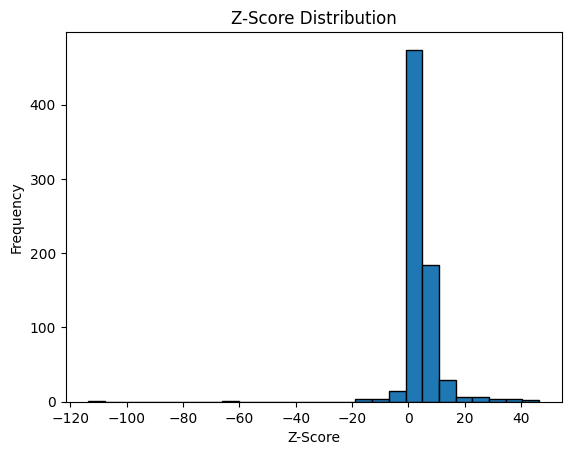

In [6]:
print(df['z_score'].describe())  

# Histogram
bins =  int(math.sqrt(len(df.index))) # number of bins based on square root of number of data points
plt.hist(df['z_score'], bins=bins, edgecolor='black')
plt.title('Z-Score Distribution')
plt.xlabel('Z-Score')
plt.ylabel('Frequency')
plt.show()



This is just another proof that there are extreme outliers in the data.
Let's remove the outliers based the standard deviation (7.48) and see how the distribution looks like.

count    667.000000
mean       3.493028
std        2.699203
min       -3.360000
25%        1.345000
50%        3.160000
75%        5.195000
max       11.370000
Name: z_score, dtype: float64
count    699.000000
mean       3.758212
std        3.478529
min       -9.460000
25%        1.350000
50%        3.230000
75%        5.540000
max       17.120000
Name: z_score, dtype: float64


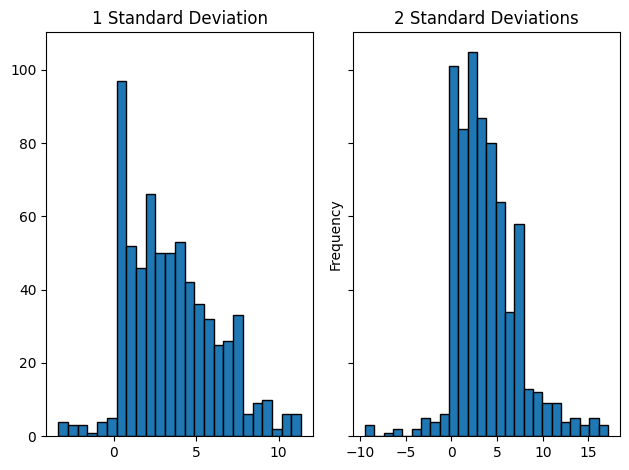

In [7]:
std = 7.48
mean = 4.03

df_1std = df.where((df['z_score'] >= mean - std) & (df['z_score'] <= mean + std)).dropna()
df_2std = df.where((df['z_score'] >= mean - 2*std) & (df['z_score'] <= mean + 2*std)).dropna()

print(df_1std['z_score'].describe())
print(df_2std['z_score'].describe())

bins1 = int(math.sqrt(len(df_1std.index)))
bins2 = int(math.sqrt(len(df_2std.index)))

fig, axs = plt.subplots(1, 2, sharey=True, tight_layout=True)
plt.ylabel('Frequency')
axs[0].hist(df_1std['z_score'], bins=bins1, edgecolor='black')
axs[0].set_title('1 Standard Deviation')
axs[1].hist(df_2std['z_score'], bins=bins2, edgecolor='black')
axs[1].set_title('2 Standard Deviations')
plt.show()


Staying within a single standard deviation the number of observations drop from 731 to 667. This is still a good number of observations to work with.
The bad news is that the means is still very high at 3.49. The expected mean should be closer to 1.8, which is also the cutoff point for the grey zone according to Altman. However, considering that the data we're working with aren't just random companies, but sourced from a high perfoming index, this might be a reasonable result. We should save this smaller dataset for future use.

Interesting are the companies with negative scores, let's take a look at them.

In [ ]:
#df_1std.drop(columns=['Unnamed: 0'], inplace=True)
#df_1std.to_csv('./datasets/1std_dataset.csv', index=False)

A correlation matrix is a good way to visualize the relationships between the variables. This might give us insight into the behind the negative Z-scores and explain how these outliers are formed.

In [9]:
negative_scores = df_1std.where(df_1std['z_score']<0).dropna()
negative_z_score_analysis = negative_scores[['symbol', 'year', 'z_score', 'totalCurrentAssets', 'totalAssets', 'retainedEarnings', 'ebitda', 'depreciationAndAmortization_income_statement', 'totalLiabilities', 'marketcap', 'revenue']]


Since the Z-score is based on 5 ratios and not just the raw variables, we should also create a matrix with those ratios. These ratios should have a stronger correlation to the Z-score, comparitively.

In [10]:
negative_z_score_analysis['ebit'] = negative_z_score_analysis['ebitda'] - negative_z_score_analysis['depreciationAndAmortization_income_statement']
negative_z_score_analysis = negative_z_score_analysis.drop(columns=['ebitda', 'depreciationAndAmortization_income_statement'])
negative_z_score_analysis['A'] = negative_z_score_analysis['totalCurrentAssets'] / negative_z_score_analysis['totalAssets']
negative_z_score_analysis['B'] = negative_z_score_analysis['retainedEarnings'] / negative_z_score_analysis['totalAssets']
negative_z_score_analysis['C'] = negative_z_score_analysis['ebit'] / negative_z_score_analysis['totalAssets']
negative_z_score_analysis['D'] = negative_z_score_analysis['marketcap'] / negative_z_score_analysis['totalLiabilities']
negative_z_score_analysis['E'] = negative_z_score_analysis['revenue'] / negative_z_score_analysis['totalAssets']

negative_z_score_analysis.to_csv('./datasamples/negative_z_score_analysis.csv', index=False)

C:\Users\bicic\AppData\Local\Temp\ipykernel_22552\3429416264.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  negative_z_score_analysis['ebit'] = negative_z_score_analysis['ebitda'] - negative_z_score_analysis['depreciationAndAmortization_income_statement']


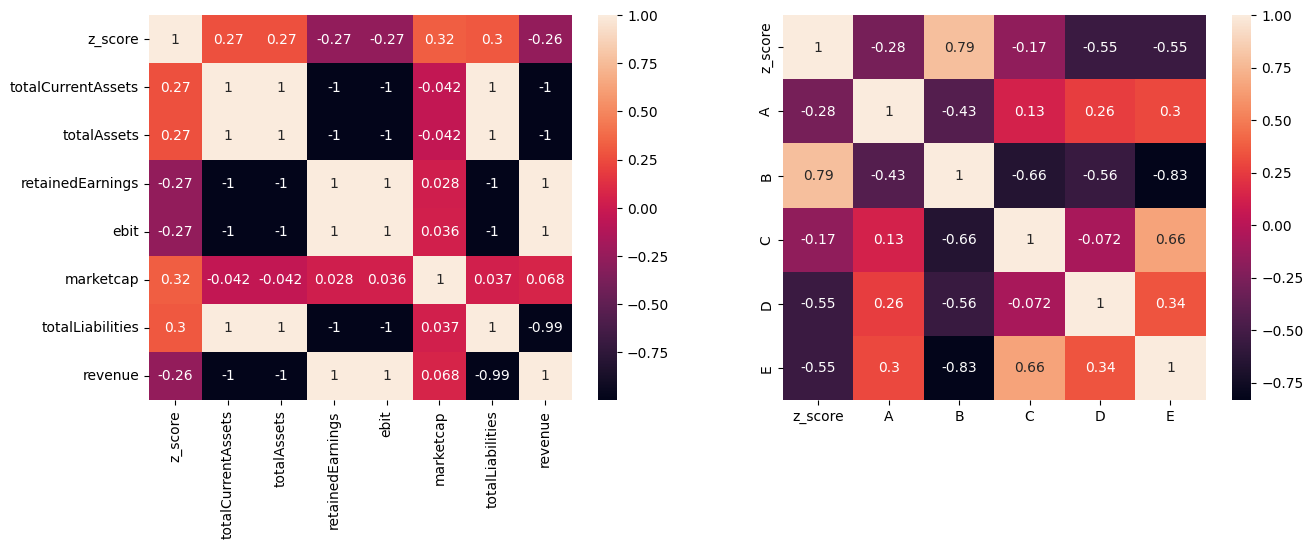

In [11]:
corr_data_raw = negative_z_score_analysis[['z_score', 'totalCurrentAssets', 'totalAssets', 'retainedEarnings', 'ebit', 'marketcap', 'totalLiabilities', 'revenue']]
corr_data_z = negative_z_score_analysis[['z_score','A', 'B', 'C', 'D', 'E']]

matrix1 = corr_data_raw.corr(numeric_only=True)
matrix2 = corr_data_z.corr(numeric_only=True)

fig, axs = plt.subplots(ncols=2, figsize=(15, 5))
sns.heatmap(matrix1, annot=True, ax=axs[0])
sns.heatmap(matrix2, annot=True, ax=axs[1])
plt.show()

Now we have to matrices showing correlations between the Altman Z-Score and the datapoints of the companies with negative scores.
The first matrix show the correlations of the datapoints as given in the dataset.
The second matrix shows the correlations of the ratios used by the Altman Z-Score calculation.
Here we see that 'B', the retained Earnings to total Assets ratio has the strongest correlation to the z-score.

Looking at the data, we see that all retained earnings are negative in this subset.

Let's create the second matrix using the entire dataset, and compare two matrices.

C:\Users\bicic\AppData\Local\Temp\ipykernel_22552\3742848001.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  complete_z_score_analysis['ebit'] = complete_z_score_analysis['ebitda'] - complete_z_score_analysis['depreciationAndAmortization_income_statement']


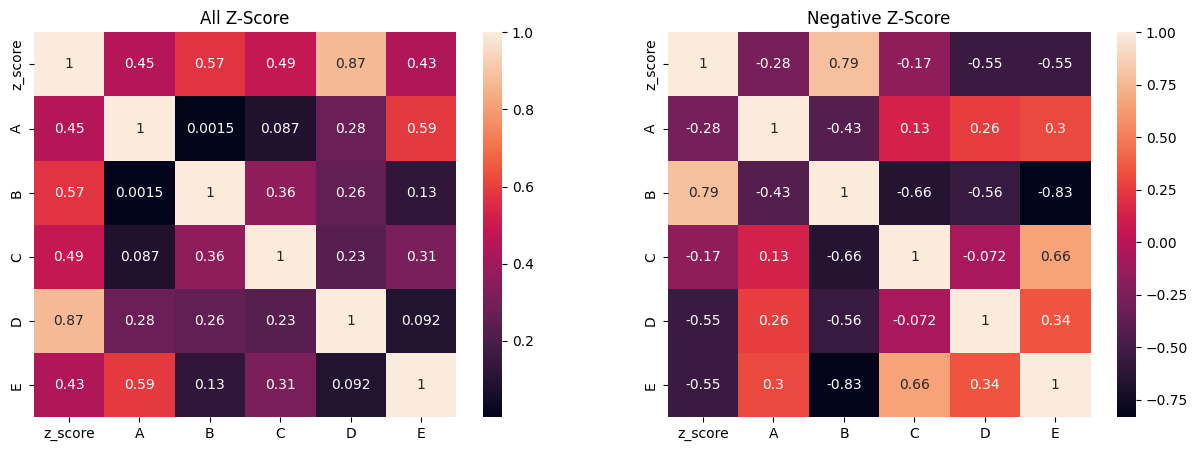

In [12]:
complete_z_score_analysis = df_1std[['symbol', 'year', 'z_score', 'totalCurrentAssets', 'totalAssets', 'retainedEarnings', 'ebitda', 'depreciationAndAmortization_income_statement', 'totalLiabilities', 'marketcap', 'revenue']]
complete_z_score_analysis['ebit'] = complete_z_score_analysis['ebitda'] - complete_z_score_analysis['depreciationAndAmortization_income_statement']
complete_z_score_analysis = complete_z_score_analysis.drop(columns=['ebitda', 'depreciationAndAmortization_income_statement'])
complete_z_score_analysis['A'] = complete_z_score_analysis['totalCurrentAssets'] / complete_z_score_analysis['totalAssets']
complete_z_score_analysis['B'] = complete_z_score_analysis['retainedEarnings'] / complete_z_score_analysis['totalAssets']
complete_z_score_analysis['C'] = complete_z_score_analysis['ebit'] / complete_z_score_analysis['totalAssets']
complete_z_score_analysis['D'] = complete_z_score_analysis['marketcap'] / complete_z_score_analysis['totalLiabilities']
complete_z_score_analysis['E'] = complete_z_score_analysis['revenue'] / complete_z_score_analysis['totalAssets']

complete_corr_data = complete_z_score_analysis[['z_score','A', 'B', 'C', 'D', 'E']]

complete_matrix = complete_corr_data.corr(numeric_only=True)
negative_matrix = corr_data_z.corr(numeric_only=True)

fig, axs = plt.subplots(ncols=2, figsize=(15, 5))
sns.heatmap(complete_matrix, annot=True, ax=axs[0])
sns.heatmap(negative_matrix, annot=True, ax=axs[1])
axs[0].set_title('All Z-Score')
axs[1].set_title('Negative Z-Score')
plt.show()

In comparison, the correlation of B is weaker in the full dataset, but it's still decently strong.
The strongest correlation is now D, Market Cap to Total Liabilities ratio. Which I believe logically makes sense, as we're dealing with companies that have been sourced from a high performing index.